After the model has been fit to and subtracted out, the final step is detecting residuals. There are a lot of ways to do this, so I'm going to try to do a few of them here to see how they shake out. 

###Load Data
First thing's first load in the data. I'm going to load in the data from one of my sample runs, in the form of a numpy array. This is the form that my data comes out in the code after a fit is performed. It's possible to transform it into a fits image, and I actually do that later in this notebook. 

In [1]:
#remember to change this on your machine. 
directory = '/home/jeffrey/Bayesian_Image_Modeling/Fit_Many_Images/residualArrays/'
filename = 'CFHTLS_072_2003'
import numpy as np
import os
#from time import time
#np.random.seed(int(time()))

#filename = np.random.choice(os.listdir(directory))
filename = directory+filename

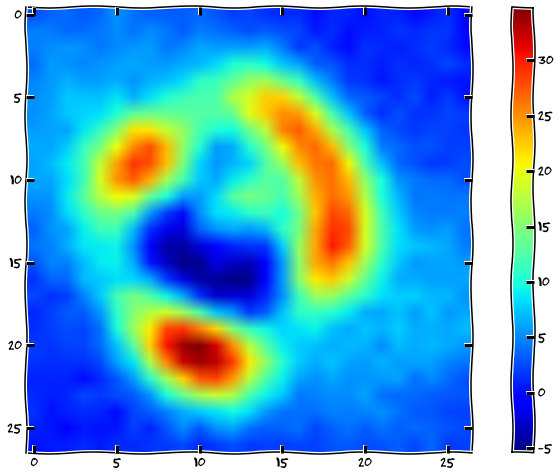

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.xkcd()
from IPython.core.pylabtools import figsize
figsize(14,8)

#load and plot
image  = np.loadtxt(filename, delimiter = ',')
im = plt.imshow(image)
plt.colorbar(im)
plt.show()

There are at least 10 pixels 2 sigma above backgroud: True


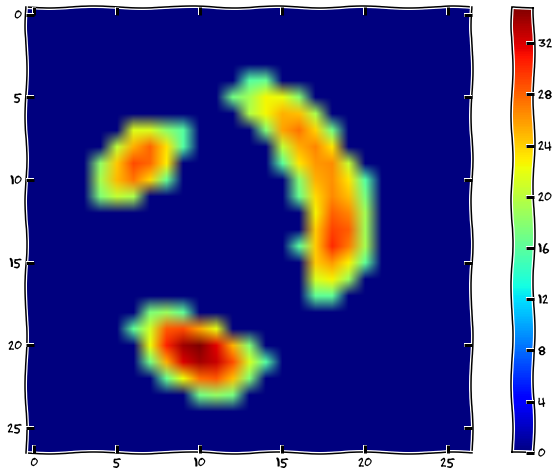

In [3]:
from copy import deepcopy
std = image.std()
mean = image.mean()
threshold = mean+1*std #if there are pixels where the value is 3 std's greater than the mean

threshImage = deepcopy(image)
threshImage[threshImage<threshold] = 0 #assign all negative values to 0

print 'There are at least 10 pixels 2 sigma above backgroud: %s'%(np.sum(image>threshold)>10) #10 pixels over the threshold
im = plt.imshow(threshImage)
plt.colorbar(im)
plt.show()

Pretty clear, and there are results for an increase of several standard deviations too. The trouble is you have to identify that the pixels over threshold are in fact clumped together. This can be done with any unsupervised learning thing like sklearn. 

3 clusters identified.


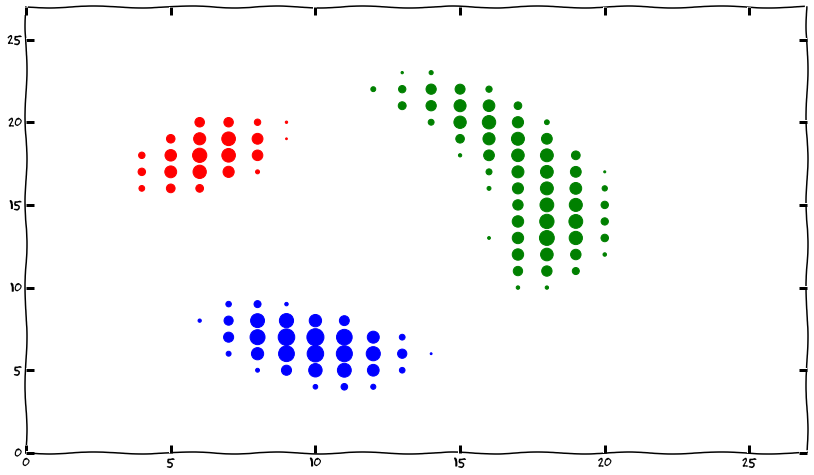

In [4]:
from sklearn.cluster import DBSCAN
agg = DBSCAN(eps = 2, min_samples = 6)

data = []
img_y, img_x = image.shape
for x in xrange(img_x):
    for y in xrange(img_y):
        if image[y,x]>threshold:
            data.append([y,x])
            
data = np.array(data)

agg.fit(data)
labels = agg.labels_
print '%d clusters identified.'%len(set(labels))
if -1 in labels:
    print 'Noise Cluster identified and not plotted.'
colors = ['r', 'b', 'g', 'm', 'c', 'y', 'k']
for i, color in enumerate(colors):
    d =data[labels ==i]
    s = []
    for idx in d:
        val = (image[tuple(idx)]-threshold)*15
        s.append(val)
    plt.scatter(d[:,1], img_y-d[:,0], color = color, s = s)
    
plt.xlim(0, img_x)
plt.ylim(0, img_y)
figsize(12,12)
plt.show()

So the clustering algorithm identified 3 clusters in the image, each corresponding to a piece of the lens. Occasionally, if a 'blip' is too small, the clustering algorithm will peg it as noise and not plot it. 

###SExtractor
So that worked alright, but I want to compare to how SExtractor handles it. I'll run sextractor on it below. 

In [5]:
#save the image to file locally as a fits file. 
figsize(14,8)
import pyfits
import os
hdu = pyfits.PrimaryHDU(image)
fname = 'image.fits'
#uncomment if there is an error. I don't want to delete stuff in your directory without you acknowledging it manually. 
if fname in os.listdir(os.getcwd()):
   os.remove(fname)
hdu.writeto(fname)

Now, I have to copy the sextractor params over to run in this directory. 

In [6]:
%%bash
cp /usr/local/share/sextractor/default* .

cp: cannot stat '/usr/local/share/sextractor/default*': No such file or directory


I'm modifying the param file to get the x and y locations of the objects. There is a wealth of other information I could get but I'm not worried about any of that now. 

In [69]:
lines = []
#I'm only interested in identifyin the objects
params = set(['X_IMAGE', 'Y_IMAGE'])
with open('default.param') as f:
    for line in f:
        var = line[1:line.find(' ')].strip()
        if var in params:
            line = line[1:]
        lines.append(line)
        
paramText = ''.join(lines)
with open('default.param', 'w') as f:
    f.write(paramText)

In [70]:
%%bash
sex image.fits -CHECKIMAGE_TYPE OBJECTS

> 
----- SExtractor 2.19.5 started on 2014-08-06 at 10:20:13 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing check-image(s)
> Initializing catalog
> Looking for image.fits
----- Measuring from: image.fits
      "Unnamed" / no ext. header / 27x27 / 64 bits (floats)
Detection+Measurement image: > Setting up background maps
> Filtering background map(s)
> Computing background d-map
> Computing background-noise d-map
(M+D) Background: 4.63273    RMS: 4.99644    / Threshold: 7.49467    
> Scanning image
> Line:   25  Objects:        3 detected /        0 sextracted
> Line:   27  Objects:        3 detected /        0 sextracted
      Objects: detected 3        / sextracted 3               

> Closing files
> 
> All done (in 0.0 s: 6078.4 lines/s , 675.4 detections/s)


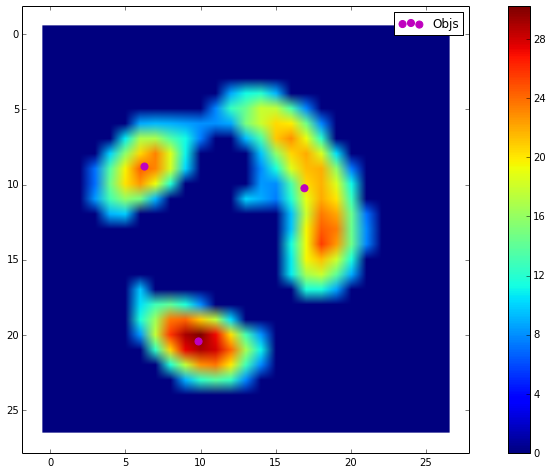

In [71]:
#the output file for sextractor is formatted in an extremely unusual way. 
#it makes it difficult to read in, so I have to do this nonsense to get the coordinates out. 
coords = []
with open('test.cat') as f:
    for line in f:
        if line[0] =='#':
            continue 
        line = line.strip()
        splitLine = line.split(' ')
        out = []
        for x in splitLine:
            if x:
                out.append(float(x))
        coords.append(out)
        
#sextractor also uses a 1-based indexing system for god knows what reason. 
coords = np.array(coords)-1 

#open the check image which holds only the object, and plot. 
checkImage = pyfits.open('check.fits')
data = checkImage[0].data
im = plt.imshow(data)
plt.colorbar(im)

plt.scatter(coords[:,0], coords[:,1], color = 'm', s= 50, label = 'Objs')
plt.legend()
plt.show()

Sextractor got the same objects as I did, but obviously got them much better than me. There is also a lot more available to do from sextractor, and I don't know what of it's many tools will be useful. 

###Improvements on my extractor
There is a lot that SExtractor has to offer. However, it may be a little bit too much for what I'm trying to develop. What I'm interested in doing is developing a simple series of tests that will determine if something probably is a lens or not. I can add, remove and move around any of them as I go along, but I'll start with:

-number of objects >= 2.

-Centers of light distributions are approximately equidistant from the center of the image. 

-The major axes of the distributions are roughly perpendicular to the line toward the center of the image.

Below I reenter the data before starting. I won't do an nObjects count because I kind of already did that with my clustering algorithm. I will however gather the clusters in a Residual object, allowing me to store data in the same place for each one. 

In [7]:
class Residual(object):
    
    def __init__(self, pointsSet, key, image, color):
        
        self.pointsSet = pointsSet #a set of all points in tuples, for membership and accessing image pixels
        self.points = np.array(list(pointsSet)) #an np array of points.  
        
        self.key = key# the key to access the Residual in the dictionary, 'Noise' or 0,1,2...
        if self.key == -1:
            self.key = 'Noise'
        self.image = image # a reference to the image this object comes from
        self.color = color #the color to use in plotting, for consistency. 
        
        self.center, self.dist, self.vect, self.theta = self._findMoments() #find the center of this residual and it's distance from the center
        self.a, self.b = self.vect
        
    def __contains__(self, item):
        return self.pointsSet.__contains__(item)
    
    def __iter__(self):
        return self.pointsSet.__iter__()
      
    def getXY(self):#returns the x and y as separate arrays, for plotting
        return self.points[:,1], self.points[:,0]
    
    def _findMoments(self): #find the moments of the distribution
        Ix = Iy = Ixx = Iyy = Ixy = I = long(0)
        
        for idx in self.pointsSet:
            y,x = idx
            val = self.image[idx]
            I+=val
            Ix+=x*val
            Iy+=y*val
            Ixx+=x*x*val
            Iyy+=y*y*val
            Ixy+=x*y*val
            
        xmean = Ix/I
        ymean = Iy/I
              
        img_y, img_x = self.image.shape
        imgCenterY, imgCenterX = img_y/2.0, img_x/2.0
        
        #the distane of the center of the light from the center of the distribution
        dist = np.sqrt((xmean-imgCenterX)**2+(ymean-imgCenterY)**2)
        
        Uxx = Ixx/I-xmean**2
        Uyy = Iyy/I-ymean**2
        Uxy = Ixy/I-xmean*ymean
        
        theta = .5*np.arctan(2.0*Uxy/(Uxx-Uyy))
        
        lambda1 = .5*(Uxx+Uyy)+.5*np.sqrt(4*Uxy**2+(Uxx-Uyy)**2)
        lambda2 = .5*(Uxx+Uyy)-.5*np.sqrt(4*Uxy**2+(Uxx-Uyy)**2)
        
        return (ymean, xmean), dist, (np.sqrt(lambda1), np.sqrt(lambda2)), theta 
    
    def isNoise(self):
        return self.key == 'Noise'
                

I've made the object, now let's apply it to our image. 

In [8]:
image  = np.loadtxt(filename, delimiter = ',')
std = image.std()
mean = image.mean()
nSigma = 1
threshold = mean+nSigma*std #if there are pixels where the value is n std'

agg = DBSCAN(eps = 2, min_samples = 6)

#gather the x y data
data = []
img_y, img_x = image.shape
for x in xrange(img_x):
    for y in xrange(img_y):
        if image[y,x]>threshold:
            data.append([y,x])
            
data = np.array(data)

agg.fit(data)
labels = agg.labels_

#gather the clusters into the dictionary
nClusters = len(set(labels))
clustRange = xrange(nClusters)
if -1 in labels:
#noise cluster identified
    clustRange = xrange(-1, nClusters-1)

colors = ['r', 'b', 'g', 'm', 'c', 'y', 'k']
residuals = {}
for i, color in zip(clustRange, colors):
    #gather the points by cluster and create their cluster object. 
    cluster = set()
    d = data[labels == i]

    for idx in d:
        cluster.add(tuple(idx))

    if i == -1:
        residuals['Noise'] = Residual(cluster, 'Noise',image, color)
    else:
        residuals[i] =Residual(cluster, i, image, color)
    

And now, plot, for santy's sake. 

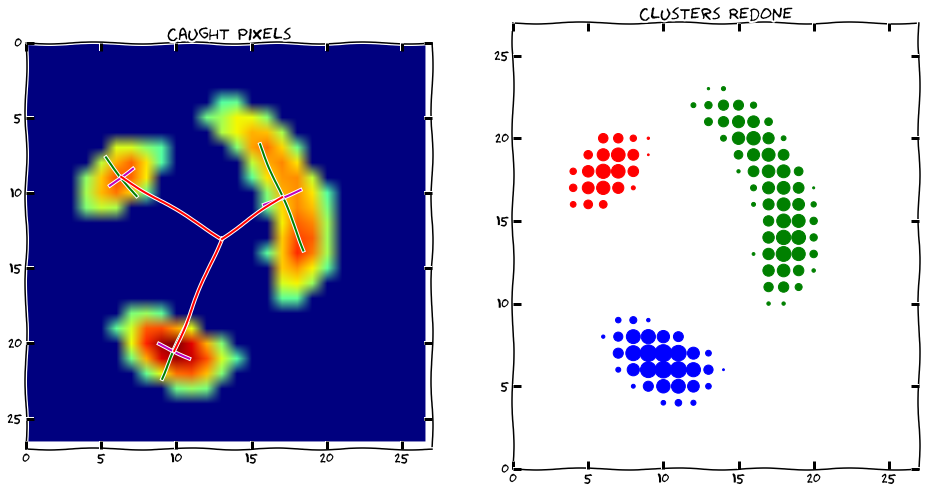

In [9]:
threshImage = np.where(image>threshold, image, 0)
figsize(16,8)
plt.subplot(121)
plt.title('Caught Pixels')
plt.imshow(threshImage)

plt.subplot(122)   

for residual in residuals.itervalues():
    plt.subplot(122)
    if residual.isNoise():
        continue
    
    s = []
    for idx in residual:
        val = (image[idx]-threshold)*15
        s.append(val)
    
    xx, yy = residual.getXY() 
    plt.scatter(xx, img_y-yy, color = residual.color, s = s)
    
    plt.subplot(121)
    plt.xlim(0,img_x )
    plt.ylim(img_y, 0)
    yc, xc = residual.center
    a, b = residual.a, residual.b
    #Theta seems to be coming out wrong. 
    theta = -1*residual.theta
    
    plt.scatter(xc, yc, color = 'k')
    plt.plot((xc - a * np.sin(theta), xc + a * np.sin(theta)), \
               (yc - a * np.cos(theta), yc + a * np.cos(theta)), color='g')

    plt.plot((xc - b * np.cos(theta), xc + b * np.cos(theta)), \
              (yc + b * np.sin(theta), yc - b * np.sin(theta)), color='m')
    imgCx, imgCy = (img_x-1)/2.0, (img_y-1)/2.0
    plt.plot((xc, imgCx), (yc, imgCy), color = 'r')
   
plt.subplot(122)  
plt.xlim(0, img_x)
plt.ylim(0, img_y)
plt.title('Clusters Redone')
plt.show()

Everything works as expected, so let's begin designing a pipeline. The first factor of interest will be the number of identified objects. The images will be subdivided into cases where:

nObjects = 0: Not a lens, and nothing to check anyway

nObjects = 1: Possibly a lens. Possibly a complete "ring", or one stray arc. Test for both cases.

nObjects = 2: Multiple causes. Ideally, it'd be 2 objects on either side of one another from the lensed image. It's possible that they could be on the same side as one another, in which case check for comparable distance. 

nObjects >= 3: Similar to 2. Check if they are comparable distances from the center. Also, check that the major axes are all perpindicular to the line toward the center of the image. 

I'll design that below. 

In [10]:
def checkLens(residuals):
    
    nObjects = len(residuals)
    if 'Noise' in residuals:
        nObjects -=1 #ignore noise
        
    if nObjects <1:
        return False 
    
    image = residuals[0].image
    
    if nObjects == 1:
        residual = residuals[0]
        center_difference = 3 #the distance from the center the ring is allowed to be. 
        if residual.dist<=center_difference:
            return True
        
        return False
            
    else: #nObjects >2
        
        enoughPerp = False
        closeTogether = False
        imgCy, imgCx = (image.shape[0]-1)/2.0, (image.shape[1]-1)/2.0
        
        objs = [residuals[i] for i in xrange(nObjects)]
        slopes = [(obj.center[0]-imgCy)/float(obj.center[1]-imgCx) for obj in objs]
        
        properlyOriented = 0
        for obj, slope in zip(objs, slopes):
            
            theta = -1*obj.theta #seems to come out negative; not sure if it's a plotting error or what. 
            axesSlope = 1/np.tan(theta)
            #maybe I should be specifically checking the major axis, rather than just one indiscriminately as perp/parallel
            properlyOriented+= 1 if .1<abs(axesSlope/slope)<10 else 0 #comparable in magnitude
        
        enoughPerp = properlyOriented >1 #if there is more than one lined up well
        
        #the differences betwe
        diffs = []
        for i, obj in enumerate(objs):
            for obj2 in objs[i+1:]:
                diffs.append(abs(obj.dist-obj2.dist))
                
        diffs = np.array(diffs)
        closeTogether = diffs.mean()<3 #arbitrary number. 
        
        if nObjects == 2: #special case
            slope1, slope2 = slopes[0], slopes[1]
            ratio = slope1/slope2
            #i'm not sure if you want a positive slope or allow a slight negative difference, for a 'kink'
            acrossOneAnother= ratio>-.2 and .1<abs(ratio)<10 #opposite sides and comparable slopes
            return (acrossOneAnother and enoughPerp) or (acrossOneAnother and closeTogether \
                        or enoughPerp and closeTogether)#any 2
        
        return closeTogether and enoughPerp
    
print checkLens(residuals)

True


Ok, now for the big test. I'm going to run this test over all the samples I have saved locally. 

In [11]:
directory = '/home/jeffrey/Bayesian_Image_Modeling/Fit_Many_Images/residualArrays/'

def makeResidualsDict(filename): #makes a dict of Residual objects from a filename
    
    image  = np.loadtxt(filename, delimiter = ',')
    std = image.std()
    mean = image.mean()
    nSigma = 1
    threshold = mean+nSigma*std #if there are pixels where the value is n std'
    
    agg = DBSCAN(eps = 2, min_samples = 6)
    
    #gather the x y data
    data = []
    img_y, img_x = image.shape
    for x in xrange(img_x):
        for y in xrange(img_y):
            if image[y,x]>threshold:
                data.append([y,x])
                
    data = np.array(data)
    
    agg.fit(data)
    labels = agg.labels_
    
    #gather the clusters into the dictionary
    nClusters = len(set(labels))
    clustRange = xrange(nClusters)
    if -1 in labels:
    #noise cluster identified
        clustRange = xrange(-1, nClusters-1)
    
    colors = ['r', 'b', 'g', 'm', 'c', 'y', 'k']
    residuals = {}
    for i, color in zip(clustRange, colors):
        #gather the points by cluster and create their cluster object. 
        cluster = set()
        d = data[labels == i]
    
        for idx in d:
            cluster.add(tuple(idx))
    
        if i == -1:
            residuals['Noise'] = Residual(cluster, 'Noise',image, color)
        else:
            residuals[i] =Residual(cluster, i, image, color)
            
    return residuals

def plotResiduals(residuals): #plots all info for the residual. 
    image = residuals[0].image
    threshold = image.mean()+image.std()
    threshImage = np.where(image>threshold, image, 0)
    figsize(16,8)
    plt.subplot(121)
    plt.title('Caught Pixels')
    plt.imshow(threshImage)
    
    plt.subplot(122)   
    
    for residual in residuals.itervalues():
        image = residuals[0].image
        img_y, img_x = image.shape
        plt.subplot(122)
        if residual.isNoise():
            continue
        
        s = []
        for idx in residual:
            val = (image[idx]-threshold)*15
            s.append(val)
        
        xx, yy = residual.getXY() 
        plt.scatter(xx, img_y-yy, color = residual.color, s = s)
        
        plt.subplot(121)
        plt.xlim(0,img_x )
        plt.ylim(img_y, 0)
        yc, xc = residual.center
        a, b = residual.a, residual.b
        #Theta seems to be coming out wrong. 
        theta = -1*residual.theta
        
        plt.scatter(xc, yc, color = 'k')
        plt.plot((xc - a * np.sin(theta), xc + a * np.sin(theta)), \
                   (yc - a * np.cos(theta), yc + a * np.cos(theta)), color='g')
    
        plt.plot((xc - b * np.cos(theta), xc + b * np.cos(theta)), \
                  (yc + b * np.sin(theta), yc - b * np.sin(theta)), color='m')
        imgCx, imgCy = (img_x-1)/2.0, (img_y-1)/2.0
        plt.plot((xc, imgCx), (yc, imgCy), color = 'r')
       
    plt.subplot(122)  
    plt.xlim(0, img_x)
    plt.ylim(0, img_y)
    plt.title('Clusters Redone')
    plt.show()

CFHTLS_047_0155 was identified as a lens.
------------------------------
CFHTLS_047_1845 was identified as a lens.
------------------------------
CFHTLS_047_0790 was identified as a lens.
------------------------------
CFHTLS_047_1846 was not identified as a lens.


/home/jeffrey/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars


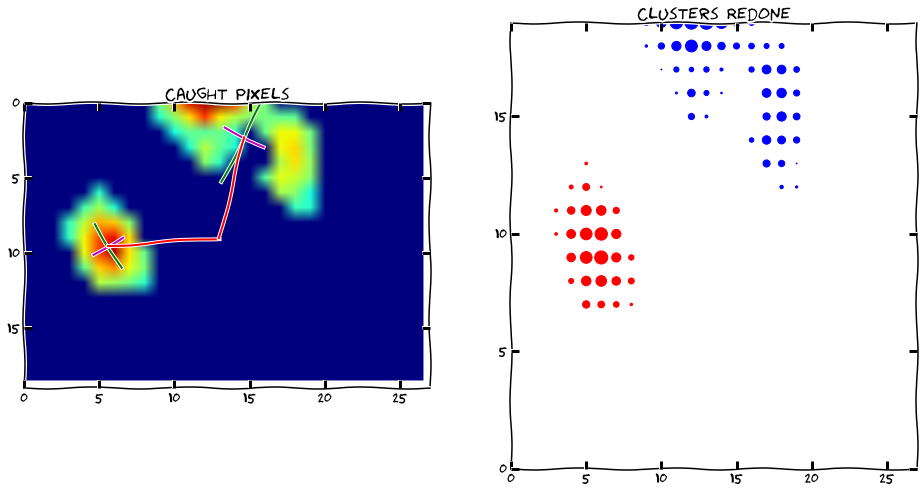

------------------------------
CFHTLS_072_2003 was identified as a lens.
------------------------------
CFHTLS_047_0855 was identified as a lens.
------------------------------
CFHTLS_047_1014 was identified as a lens.
------------------------------
CFHTLS_047_1866 was identified as a lens.
------------------------------
CFHTLS_047_0118 was not identified as a lens.


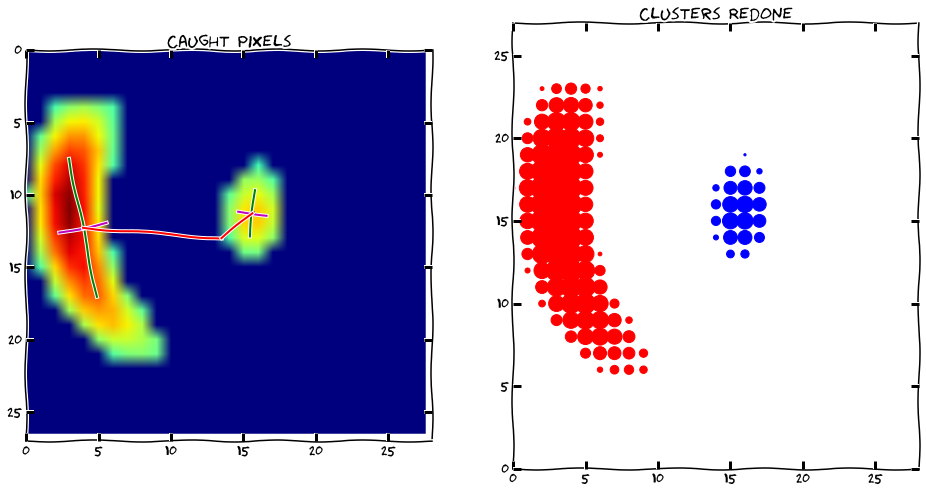

------------------------------
CFHTLS_047_1988 was not identified as a lens.


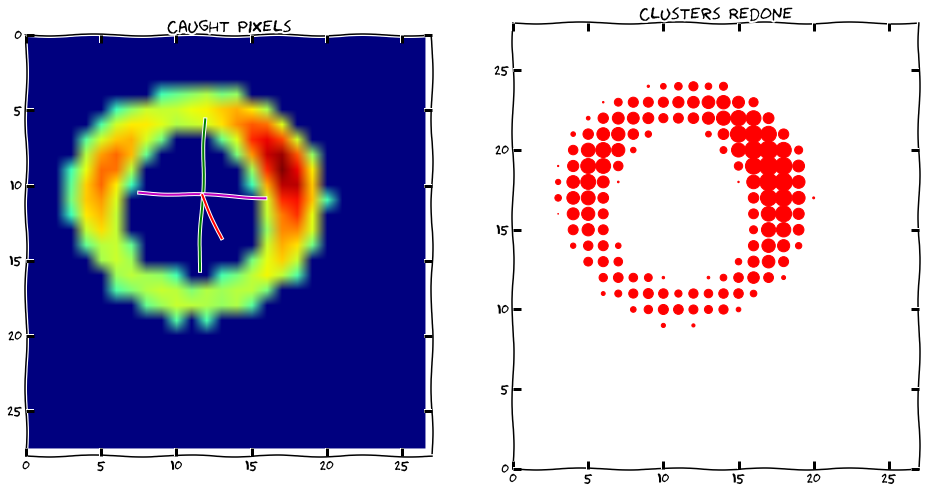

------------------------------
CFHTLS_047_0987 was identified as a lens.
------------------------------
CFHTLS_047_0988 was identified as a lens.
------------------------------


In [12]:
directory = '/home/jeffrey/Bayesian_Image_Modeling/Fit_Many_Images/residualArrays/'
filenames =os.listdir(directory)

for fname in filenames:
    filename = directory+fname
    residuals = makeResidualsDict(filename)
    if checkLens(residuals):
        print '%s was identified as a lens.'%fname
    else:
        print '%s was not identified as a lens.'%fname
        plotResiduals(residuals)
    print '-'*30

It worked pretty well. Some here that it failed on, but I don't know if I want to correct them. It may be a good idea to package the center of the image with the object (though I don't have them right now; I'd have to re-run my simulation to get them). The 1st one fails because it mis-identifies the center of the structure. 